### Our approach is to extract the hand landmark using Tensorflow's hand detection model and use the 21 hand keypoints to train as features. On the front end, we also use the same detection model but in real-time and pass that into this trained model to predict the ASL character.

## Loading data from kaggle

In [1]:

!kaggle datasets download -d grassknoted/asl-alphabet
!unzip asl-alphabet.zip
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task
!pip install mediapipe
!pip install tensorflowjs


Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing2056.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing2057.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing2058.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing2059.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing206.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing2060.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing2061.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing2062.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing2063.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing2064.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing2065.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing2066.jpg  
  inflating: asl_alphabet_

### Importing dependencies and helper functions

In [2]:
import mediapipe as mp
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

## Data Preprocessing

In [20]:
base_path = './asl_alphabet_train/asl_alphabet_train/'

df = pd.DataFrame()

for folder in os.listdir(base_path):
    df[folder] = os.listdir(base_path + folder)

# Load data into dictionary, categorized by characters
data = df.to_dict(orient="list")


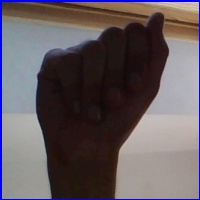

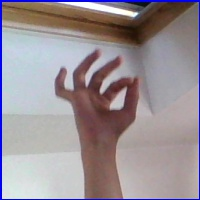

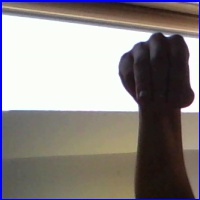

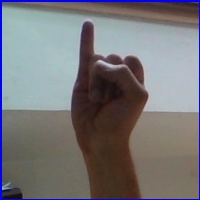

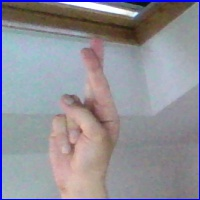

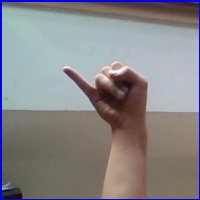

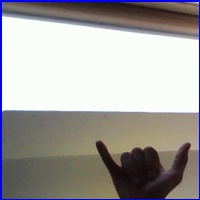

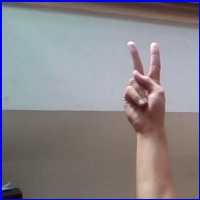

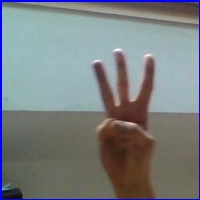

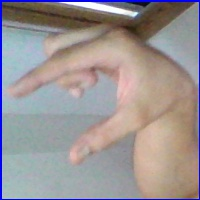

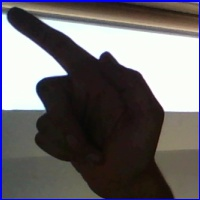

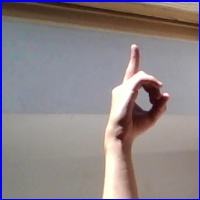

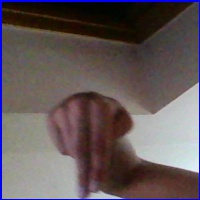

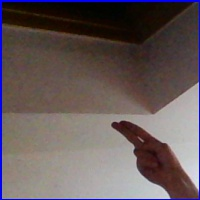

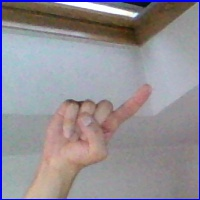

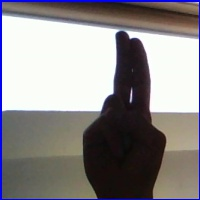

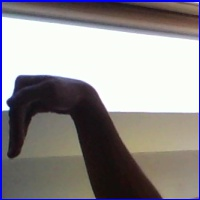

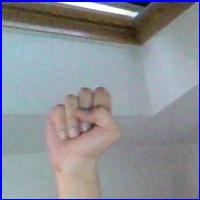

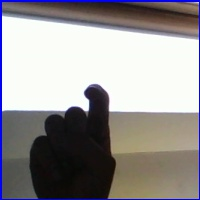

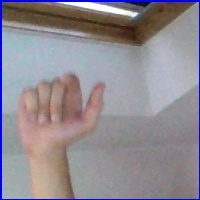

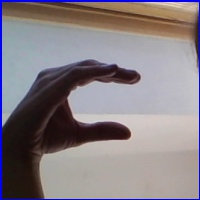

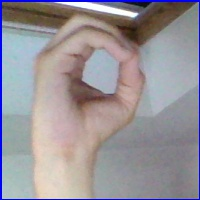

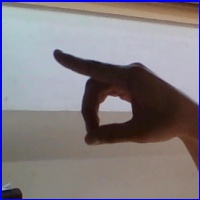

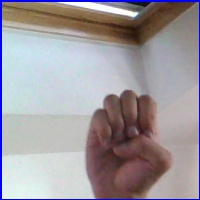

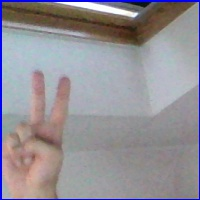

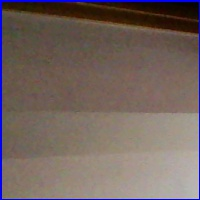

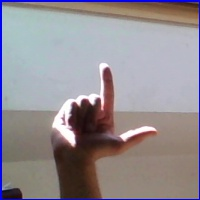

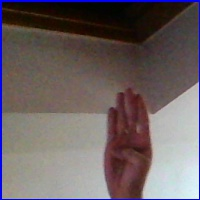

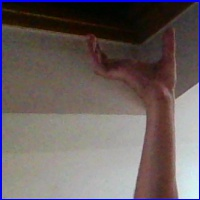

In [21]:
from google.colab.patches import cv2_imshow

# View images
for key in data.keys():
  cv2_imshow(cv2.imread(base_path + f"{key}/{data[key][100]}"))

### Hand detection model

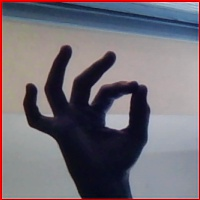

[[NormalizedLandmark(x=0.45354482531547546, y=0.9507838487625122, z=1.5357090887846425e-06, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5892353057861328, y=0.8314435482025146, z=-0.05744306370615959, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.6731517314910889, y=0.6986656785011292, z=-0.07218966633081436, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.7087067365646362, y=0.5710809826850891, z=-0.08215753734111786, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.7035630941390991, y=0.46174365282058716, z=-0.08861824870109558, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.49828970432281494, y=0.5922511219978333, z=-0.01618206314742565, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5364802479743958, y=0.47790610790252686, z=-0.06388725340366364, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.6067785024642944, y=0.45428740978240967, z=-0.10864895582199097, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.6807408928871155, y=0.44

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


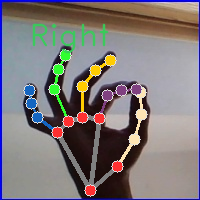

In [22]:
import mediapipe as mp

# Initialize the hand detector
baseOptions = mp.tasks.BaseOptions(model_asset_path='hand_landmarker.task')
hlo = mp.tasks.vision.HandLandmarkerOptions(
    base_options=baseOptions,
    running_mode=mp.tasks.vision.RunningMode.IMAGE,
    min_hand_detection_confidence=0.95 # Through experimentation this is the best balance
)
hands = mp.tasks.vision.HandLandmarker.create_from_options(hlo)

# Test detection on one image
img = cv2.imread(base_path + f"F/{data['F'][125]}")
img = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
cv2_imshow(img.numpy_view())
results = hands.detect(img)
print(results.hand_landmarks)
newImg = draw_landmarks_on_image(cv2.cvtColor(img.numpy_view(), cv2.COLOR_RGB2BGR), results)
cv2_imshow(newImg)

### Process the data for training

In [31]:
# Process data into np arrays
def img2vec(data):
    X, y = [], []
    count = 1
    for key in data.keys():
        print(f"{count}/{len(data.keys())}")
        count += 1
        # Skip non-aphabetic categories
        if key == 'nothing' or key == 'space' or key == 'del':
            continue
        imgCount = 0
        for img in data[key]:
            # Query a specific number of images per category
            if imgCount > 50:
                break
            cvOpen = cv2.imread(base_path + f"{key}/{img}")
            # Create both variations for the images since the dataset only includes right hand images

            for flip in [False, True]:  # Flip for left-hand signs
                if flip:
                    cvOpen = cv2.flip(cvOpen, 1)
                image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(cvOpen, cv2.COLOR_RGB2BGR))
                results = hands.detect(image)

                # Skip if no hand detected or confidence too low
                if results.hand_world_landmarks:
                    imgCount += 1
                    formatted = list(map(lambda x: [x.x, x.y, x.z], results.hand_world_landmarks[0]))
                    # Append the formated feature vector
                    X.append(np.append(np.array(formatted).flatten(), ([1] if flip else [0])))
                    y.append(key)
    return np.array(X), np.array(y)


In [32]:
# Data processing
X, y = img2vec(data)

1/29


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


2/29
3/29
4/29
5/29
6/29
7/29
8/29
9/29
10/29
11/29
12/29
13/29
14/29
15/29
16/29
17/29
18/29
19/29
20/29
21/29
22/29
23/29
24/29
25/29
26/29
27/29
28/29
29/29


In [33]:
from sklearn.model_selection import train_test_split

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(1201, 64)
(1201,)
(134, 64)
(134,)


In [34]:
from sklearn.preprocessing import LabelBinarizer

# Binarize the label index to use with MLP
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train)
y_test_binarized = lb.transform(y_test)

## Training

In [35]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

# Create the tensorflow model
model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(64,)),
    layers.Dense(300, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(26, activation='softmax')
])

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Start training
model.fit(X_train, y_train_binarized, epochs=80, batch_size=4)

Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1489 - loss: 2.9776
Epoch 2/80
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6267 - loss: 1.0762
Epoch 3/80
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7458 - loss: 0.6849
Epoch 4/80
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8154 - loss: 0.4996
Epoch 5/80
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8520 - loss: 0.4136
Epoch 6/80
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8580 - loss: 0.3526
Epoch 7/80
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8924 - loss: 0.3055
Epoch 8/80
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9014 - loss: 0.2890
Epoch 9/80
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9149 - loss: 0.2382
Epoch 10/80
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8932 - loss: 0.2501
Epoch 11/80
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9252 - loss: 0.2255
Epoch 12/80
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

## Validating

In [36]:
model.evaluate(X_test, y_test_binarized)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9945 - loss: 0.0631


[0.08559683710336685, 0.9925373196601868]

Over 99% accuracy with this method!

## Exporting model

Model is exported then convert to JSON to load on the React app

In [ ]:
import tensorflow as tf
tf.saved_model.save(model, 'model')

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model ./model ./model # Format to json for tensorflowjs